# Auto regressor

This notebook shows how to use auto_regressor.py, a very simple Python function that allows the user to fit an OLS with lagged variables.

**Model Selection:** the function automatically finds the best model available for the specified (lags of) variables. More specifically, for a given set of variables (y and set of X), the code does backward selection: remove the (lag of) variable with the highest p-value, then re-run the model, remove the least significant variable. This process is repeated until the p-values of all (lags of) variables are below the specified threshold (*p_cutoff* default is 0.05).

**...across multiple splits of the data:** to ensure that model selection is robust, the model is fit across multiple sub-samples ('splits') of the data. This means that the model is fitted separately for each split. Please note that the data is split before lags are added to avoid look-ahead bias. 

Each split is divided into a 'training set', on which the model is fitted as well as a 'test set', on which the model is tested (but not fitted). *train_share* is 0.8 by default. 

**The output of the function is the following (in order of output):**
1. Out-of-sample model performance across splits: R2, MAE, MSE, RMSE, start date and end date
2. A Pandas dataframe with the out-of-sample values across each split. This allows us to answer: how well does the model perform out-of-sample across different periods?
3. Model summary for each training split as well as the full sample: coefficients etc.
4. A Pandas dataframe that contains the model from each split, *fitted to the* **full dataset**. This answers the question: how well does a model fit on 2010-2015 data perform during 2021-2023?

# Load and import

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from stargazer.stargazer import Stargazer, LineLocation

from auto_regressor import data_preparation_splits, regression_OLS, full_df

# Use the function and get the output

## First, set the parameters:

In [2]:
file_location = "uk_data.csv"
lags = 2
splits = 3
train_share = 0.8
p_cutoff = 0.05

## Now run the function

In [3]:
df = regression_OLS(file_location = file_location, lags = lags, splits = splits, train_share = train_share, p_cutoff = p_cutoff)

The below output summarizes which (lags of) variables matter across which sub-sample as well as the full sample. 

In [4]:
df[0]

The below cell summarizes the out-of-sample performance across each of the splits. 

In [5]:
df[1]

,Sample 1,Sample 2,Sample 3
R2,-0.0322,-0.0457,-0.5044
Mae,0.4317,0.2318,0.5028
Mse,0.3160,0.0815,0.3941
Rmse,0.5621,0.2854,0.6278
Start Date,31/12/2009,29/02/2016,31/03/2022
End Date,28/02/2011,30/04/2017,30/04/2023


The below cell contains the dataframe with the out-of-sample predictions summarized above. 

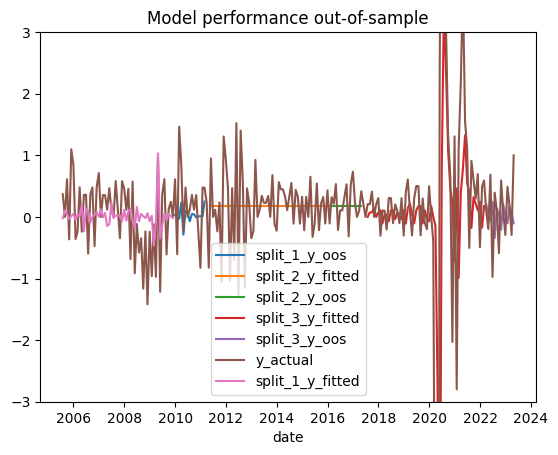

In [6]:
df[2].plot()
plt.ylim(-3, 3)
plt.title('Model performance out-of-sample');    

We apply each of the models (each fitted using their given split of data) to the full dataset (in-sample and out-of-sample, ie a mix of fitted and predicted values). 

Columns:
- The "y_fitted_ave" averages the fitted/predicted values.
- y_full_fitted is based on fitting the model to the full dataframe. This means that all the values shown are in-sample. Do not use these values for prediction. 
- "y" is the actual y value

In [7]:
df[3].tail()

,split_2_y_fitted,split_3_y_fitted,y_fitted_ave,y,y_full_fitted,split_1_y_fitted
date,,,,,,
2023-01-31,0.179872,-0.103939,0.037967,0.490677,-0.092126,0.022980
2023-02-28,0.179872,0.173742,0.176807,0.195312,0.153996,0.022872
2023-03-31,0.179872,0.069157,0.124515,-0.292398,0.061298,0.065072
2023-04-30,0.179872,-0.103534,0.038169,1.000000,-0.091767,0.016447
2023-05-31,0.179872,0.354085,0.266979,NaN,0.313844,0.035408
